# BÖLÜM 3: K-Means Kümeleme Analizi ve PCA Etkisi
### Amaç: Pazar Segmentasyonu ve Boyut İndirgeme Etkisinin Ölçülmesi
### Yöntem: PCA'siz (Ham) vs PCA'li (İndirgenmiş) K-Means Karşılaştırması

Bu bölümde, araçları teknik özelliklerine göre segmentlere ayırmak için **K-Means** algoritması kullanılmıştır.
Çalışmanın bilimsel derinliğini artırmak amacıyla, kümeleme işlemi iki farklı senaryoda test edilmiş ve sonuçları kıyaslanmıştır:
1.  **Senaryo 1:** Tüm özellikler kullanılarak (PCA Yok).
2.  **Senaryo 2:** PCA ile boyut indirgeme yapılarak (PCA Var).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Kümeleme ve Ön İşleme
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Ayarlar
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

## 1. Veri Hazırlığı ve Ölçekleme
Kümeleme işlemi uzaklık temelli olduğu için `price` (hedef değişken) çıkarılmış ve kalan tüm veriler `StandardScaler` ile aynı ölçeğe getirilmiştir.

In [9]:
# 1. Veri Yükleme
df_cluster = pd.read_csv('ekip_odevi_temizlenmis_veri.csv')

# 2. Encoding
le = LabelEncoder()
df_cluster['model'] = le.fit_transform(df_cluster['model'])
df_cluster = pd.get_dummies(df_cluster, columns=['marka', 'fuelType', 'transmission'], drop_first=True)

# 3. Hedef Değişkeni Çıkar
X_cluster = df_cluster.drop('price', axis=1)

# 4. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f"Analiz Başlıyor. Toplam Özellik Sayısı: {X_scaled.shape[1]}")

Analiz Başlıyor. Toplam Özellik Sayısı: 59


## 2. Senaryo 1: PCA Olmadan (Tüm Özelliklerle) Kümeleme
Bu aşamada, veri setindeki tüm sütunlar (boyutlar) kullanılarak K-Means algoritması çalıştırılmıştır.
* **Risk:** Çok boyutlu uzayda uzaklıkların anlamını yitirmesi (Curse of Dimensionality).

In [10]:
print(">>> Senaryo 1: PCA Olmadan (Ham Özellikler) Çalışıyor...")

# 3 Küme (Segment)
kmeans_raw = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_raw = kmeans_raw.fit_predict(X_scaled)

# Başarı Skoru
score_raw = silhouette_score(X_scaled, labels_raw)
print(f"-> PCA'siz Silhouette Skoru: {score_raw:.4f}")

>>> Senaryo 1: PCA Olmadan (Ham Özellikler) Çalışıyor...
-> PCA'siz Silhouette Skoru: 0.1244


## 3. Senaryo 2: PCA İle (İndirgenmiş Veriyle) Kümeleme
Bu aşamada, veri seti önce PCA ile 2 temel bileşene indirgenmiş, ardından kümeleme yapılmıştır.
* **Amaç:** Gürültüyü azaltmak ve kümeleri daha net ayrıştırmak.

>>> Senaryo 2: PCA Uygulanıyor ve K-Means Çalışıyor...
-> PCA'li Silhouette Skoru: 0.4647


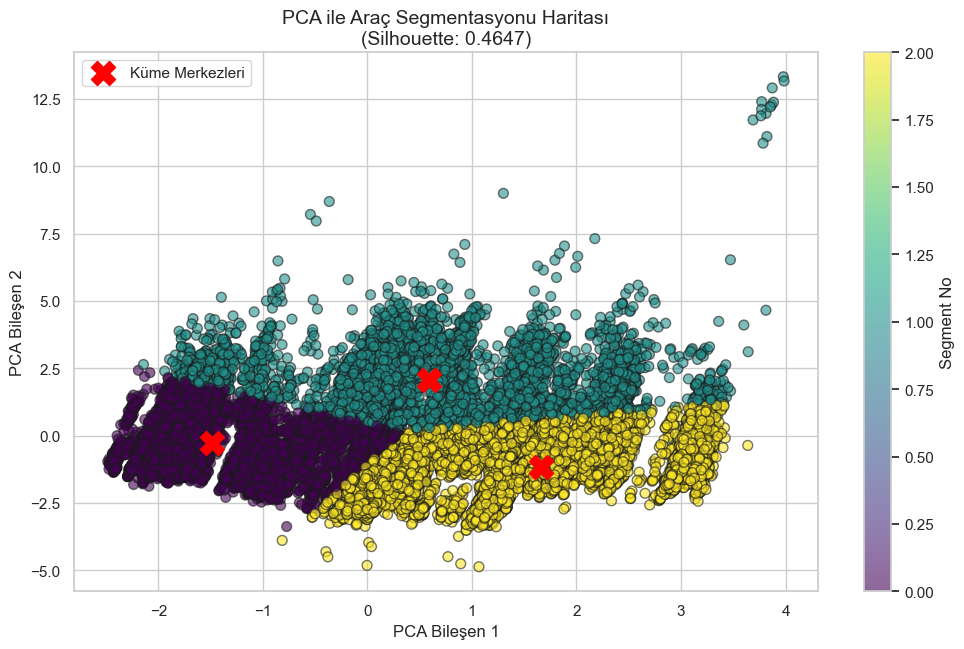

In [11]:
print(">>> Senaryo 2: PCA Uygulanıyor ve K-Means Çalışıyor...")

# PCA Uygulaması (2 Boyut)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means Eğitimi
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca)

# Başarı Skoru
score_pca = silhouette_score(X_pca, labels_pca)
print(f"-> PCA'li Silhouette Skoru: {score_pca:.4f}")

# --- SEGMENTASYON HARİTASI ---
plt.figure(figsize=(12, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca, cmap='viridis', edgecolor='k', s=50, alpha=0.6)

# Merkezler
centers = kmeans_pca.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=300, marker='X', label='Küme Merkezleri')

plt.title(f'PCA ile Araç Segmentasyonu Haritası\n(Silhouette: {score_pca:.4f})', fontsize=14)
plt.xlabel('PCA Bileşen 1')
plt.ylabel('PCA Bileşen 2')
plt.legend()
plt.colorbar(scatter, label='Segment No')
plt.show()

## 4. Sonuçların Karşılaştırılması ve Görselleştirme
Aşağıda iki senaryonun başarı skorlarını (Silhouette) karşılaştıran bir grafik ve PCA sonrası oluşan pazar segmentlerinin haritası yer almaktadır.rı**

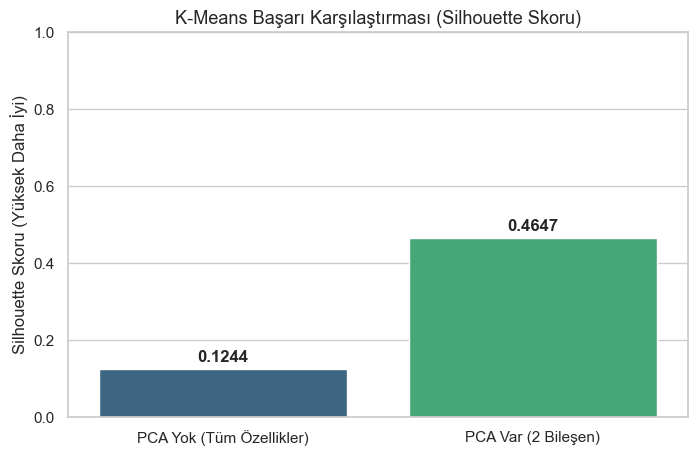

In [12]:
# --- KARŞILAŞTIRMA GRAFİĞİ ---
plt.figure(figsize=(8, 5))
scores = [score_raw, score_pca]
labels = ['PCA Yok (Tüm Özellikler)', 'PCA Var (2 Bileşen)']

ax = sns.barplot(x=labels, y=scores, hue=labels, legend=False, palette='viridis')

plt.title('K-Means Başarı Karşılaştırması (Silhouette Skoru)', fontsize=13)
plt.ylabel('Silhouette Skoru (Yüksek Daha İyi)')
plt.ylim(0, 1)

for i, v in enumerate(scores):
    ax.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()
